In [2]:
from argparse import ArgumentParser
import os
import sys
import time

import dask.dataframe as dd
import dask_geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import shapely
import xarray as xr

# from matplotlib import colors
from pandarallel import pandarallel

sys.path.insert(1, '../scripts/')
from reaches import *
from utils import *

### Parse arguments

In [3]:
# FOR NOW, SET
width_set = 'min'

# Control flow
if width_set == 'mean':
    width = 'WidthM'
    binn = 'Bin'
elif width_set == 'min':
    width = 'WidthM_Min'
    binn = 'Bin_Min'
elif width_set == 'max':
    width = 'WidthM_Max'
    binn = 'Bin_Max'
else:
    print('Invalid width option specified, exiting.')
    # sys.exit()

In [4]:
huc2 = '01' ### SET THIS
data_path = '/nas/cee-water/cjgleason/data/SWOT/PIXC_v2_0_HUC2_' + huc2
# save_dir =

### Pixel Cloud

In [5]:
# Get job index
# slurm = int(os.environ['SLURM_ARRAY_TASK_ID'])
index = 106

In [6]:
huc2 = '01'
file_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/PIXC_v2_0_HUC2_' + huc2 + '_filtered.json'
data = open_json(file_path)

In [7]:
file_name = data[index]

In [8]:
# Get data for this tile
granule_name = file_name[:-3]
tile_name = file_name[20:28]
pass_num = int(file_name[20:23])

print(granule_name)

SWOT_L2_HR_PIXC_002_007_235R_20230811T080638_20230811T080649_PGC0_01


#### Read in PIXC

In [9]:
data_path

'/nas/cee-water/cjgleason/data/SWOT/PIXC_v2_0_HUC2_01'

In [10]:
# Set PIXC filepath
pixc_path = os.path.join(data_path, file_name)

In [11]:
# Read in pixel group
ds_PIXC = xr.open_mfdataset(paths=pixc_path, group = 'pixel_cloud', engine='h5netcdf')

In [12]:
# ds_PIXC

In [13]:
def bitwiseMask(ds):
    '''
    This function masks a PIXC granules: for now, it ony remove pixels
    with land classification and those with bad geolocation_qual.
    # See page 65 of PIXC PDD: https://podaac.jpl.nasa.gov/SWOT?tab=datasets-information&sections=about%2Bdata
    '''
    # Fow now, eliminate the really bad stuff
    mask = np.where((ds.classification > 1) & 
                    (ds.interferogram_qual < 2**7) & (ds.classification_qual < 2**7) &
                    (ds.geolocation_qual < 2**7) & (ds.sig0_qual < 2**7) &
                    (np.abs(ds.cross_track) > 10000) & (np.abs(ds.cross_track) < 60000))[0]
    
    print(mask.shape)
    return mask

In [14]:
# Make mask
mask = bitwiseMask(ds_PIXC)

if mask.shape[0] == 0:
    print('This granule has no pixels after masking, exiting.')
    # sys.exit(1)    

(742270,)


In [15]:
# Set desired data vars
variables = ['azimuth_index', 'range_index', 'cross_track',
             'pixel_area', 'height', 'geoid', 'prior_water_prob',
             'classification']

In [16]:
# Convert PIXC to GeoDataFrame
gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)

### Find correct HUC4s

In [17]:
### NHDPlus HR
## Find correct HUC4s
# Read in tile and HUC4 intersection data
mdata_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC/data/'
dtype_dic= {'tile': str, 'huc4': str, 'coverage': float}
tile_huc4 = pd.read_csv(os.path.join(mdata_path,
                                    'huc4_swot_science_tiles.csv'),
                        dtype=dtype_dic)

In [18]:
# Make list of HUC4s that intersect the tile
hucs = list(tile_huc4[(tile_huc4['tile'] == tile_name)]['huc4'])
# Limit to the current HUC2
hucs = [x for x in hucs if x.startswith(huc2)]

In [19]:
hucs

['0101', '0102', '0105']

In [ ]:
# # Get NHD index metadata
# # Define dtypes for lookup tables to preserve leading zeros
# dtype_dic= {'HUC4': str, 'HUC2': str, 'toBasin': str, 'level': str}
# # Read in HUC lookup table
# huc_lookup = pd.read_csv(os.path.join(mdata_path,
#                                   'HUC4_lookup_no_great_lakes.csv'),
#                      dtype=dtype_dic)

In [ ]:
# # Extract indices for read-in
# indices = list(huc_lookup[huc_lookup['HUC4'].isin(hucs)]['slurm_index'])

### Read in HUC4 flowlines

In [51]:
data_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_' + huc2 + '/'

In [21]:
file_paths = []

for huc in hucs:
    file_path = data_path + 'NHDPLUS_H_' + huc + '_HU4_GDB_prepped_buffered_extra_' + width_set + '.parquet'
    file_paths.append(file_path)

In [22]:
file_paths

['/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_01/NHDPLUS_H_0101_HU4_GDB_prepped_buffered_extra_min.parquet',
 '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_01/NHDPLUS_H_0102_HU4_GDB_prepped_buffered_extra_min.parquet',
 '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped_buffered_extra/HUC2_01/NHDPLUS_H_0105_HU4_GDB_prepped_buffered_extra_min.parquet']

In [ ]:
# # Create merged dataframe of all flowlines intersected
# if len(indices) == 1:
#     # Read prepped NHD
#     flowlines, _, _,  = readNHD(index=indices[0])
#     # huc4_list, huc2_list = readNHD(index=indices[0])
# else:
#     # Initialize lists
#     d = []
#     # huc4_list = []
#     # huc2_list = []
#     # Loop through indices and store in lists
#     for i in indices:
#         # Read prepped NHD
#         flowlines, _, _ = readNHD(index=i)
#         # huc4, huc2 = readNHD(index=i)
#         # Append to lists
#         d.append(flowlines)
#         # huc4_list.append(huc4) # I DON'T DO ANYTHING WITH THIS
#         # huc2_list.append(huc2) # I DON'T DO ANYTHING WITH THIS
#     # Merge GeoDataFrames
#     flowlines = pd.concat(d)

In [23]:
mask = dask_geopandas.read_parquet(file_paths)

In [24]:
mask = mask.compute()

In [ ]:
# # Project CRS (currently to WGS 84 / UTM zone 18N) 
# flowlines = flowlines.to_crs(epsg=3857)

In [ ]:
# pandarallel.initialize(nb_workers=int(os.environ.get('SLURM_CPUS_PER_TASK')))

In [ ]:
# start = time.time()
# # Args are the width, cap_style, segmented=False, extra=False
# # Buffering with extra distance to capture pixels that would overlap
# # once converted to pseudo-pixels
# flowlines['buffer'] = flowlines.parallel_apply(user_defined_function=specialBuffer,
#                                                          args=(width,
#                                                                'flat', False, True),
#                                                          axis=1)
# end = time.time()
# print(end - start)

In [ ]:
# # Set geometry to buffered reaches
# flowlines = flowlines.set_geometry('buffer').set_crs(epsg=3857)

In [ ]:
# flowlines.crs

In [34]:
# Clip masked pixels to buffered reaches
gdf_PIXC_clip = gpd.sjoin(gdf_PIXC, mask, how='inner', predicate='within')

In [38]:
if gdf_PIXC_clip.shape[0] == 0:
    print('This granule has no pixels that intersect reaches, exiting.')
    # sys.exit() 

In [39]:
gdf_PIXC_clip.columns

Index(['points', 'azimuth_index', 'range_index', 'cross_track', 'pixel_area',
       'height', 'geoid', 'prior_water_prob', 'klass', 'latitude', 'longitude',
       'geometry', 'index_right', 'NHDPlusID', 'GNIS_Name', 'LengthKM',
       'WidthM', 'WidthM_Min', 'WidthM_Max', 'Bin', 'Bin_Min', 'Bin_Max',
       'StreamOrde', 'Slope'],
      dtype='object')

In [41]:
# Drop unneeded cols
gdf_PIXC_clip = gdf_PIXC_clip.drop(columns=['index_right', 'NHDPlusID',
                                            'GNIS_Name', 'LengthKM',
                                            'WidthM', 'WidthM_Min',
                                            'WidthM_Max', 'Bin', 'Bin_Min',
                                            'Bin_Max'#, 'geometry_right'
                                           ])

In [ ]:
### STOPPED HERE 02-25-25

### Nadir track

In [42]:
# Get single pixel for selecting correct nadir segment
pixel_pt = gdf_PIXC_clip.iloc[0].geometry

In [43]:
# Find correct nadir segment and return its geometry
nadir_segment_ln = findNadir(pass_num=pass_num, pixel_pt=pixel_pt)

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


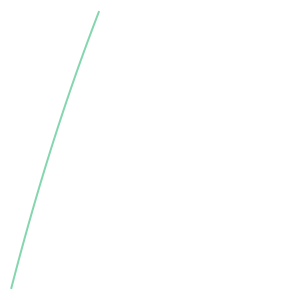

In [44]:
nadir_segment_ln

### Find alignment

In [45]:
az_nadir = calcAzimuth(line=nadir_segment_ln)

In [46]:
az_nadir

72.41249500094567

In [55]:
data_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/NHD_prepped/HUC2_' + huc2 + '/'

In [57]:
file_paths = []

for huc in hucs:
    file_path = data_path + 'NHDPLUS_H_' + huc + '_HU4_GDB_prepped.parquet'
    file_paths.append(file_path)

In [70]:
fields = ['NHDPlusID', 'GNIS_Name', 'LengthKM', 'WidthM', 'WidthM_Min',
          'WidthM_Max', 'Bin', 'Bin_Min', 'Bin_Max', 'StreamOrde',
          'Slope', 'geometry']

In [71]:
flowlines = dask_geopandas.read_parquet(path=file_paths, columns=fields)

In [72]:
flowlines = flowlines.compute()

In [74]:
flowlines['geometry'] = flowlines.geometry.explode().force_2d()

In [80]:
pandarallel.initialize(nb_workers=int(os.environ.get('SLURM_CPUS_PER_TASK')))

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [81]:
flowlines['alignment'] = flowlines.parallel_apply(user_defined_function=calcAzSin, axis=1)

In [82]:
flowlines

,NHDPlusID,GNIS_Name,LengthKM,WidthM,WidthM_Min,WidthM_Max,Bin,Bin_Min,Bin_Max,StreamOrde,Slope,geometry,alignment
0,5.000100e+12,Everett Brook,0.073,4.859201,3.686081,6.405674,"(0, 10]","(0, 10]","(0, 10]",2,0.000685,"LINESTRING (-7556035.275 5901196.189, -7556032...","(45.385231006463336, 1.0153905905644927)"
1,5.000100e+12,None,0.105,1.674413,1.270172,2.207307,"(0, 10]","(0, 10]","(0, 10]",1,0.032476,"LINESTRING (-7555827.805 5901219.53, -7555847....","(158.2433293897263, 1.0336610098995491)"
2,5.000100e+12,Hockenhull Brook,1.123,12.934905,9.812129,17.051525,"(10, 20]","(0, 10]","(10, 20]",3,0.009537,"LINESTRING (-7555480.374 5905139.585, -7555473...","(2.1993750548452624, 1.0906856673018548)"
3,5.000100e+12,Aroostook River,0.737,114.647996,86.969399,151.135493,"(100, 150]","(80, 90]","(150, 200]",6,0.000010,"LINESTRING (-7556400.402 5911602.716, -7556321...","(317.0580470022246, 1.0078349174534793)"
4,5.000100e+12,None,0.083,2.376562,1.802806,3.132918,"(0, 10]","(0, 10]","(0, 10]",1,0.017952,"LINESTRING (-7555107.4 5910151.253, -7555187.2...","(177.09039597201547, 1.0732621953012542)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17740,5.000200e+12,Machias River,1.269,39.303362,29.814649,51.811922,"(30, 40]","(20, 30]","(50, 60]",5,0.000010,"LINESTRING (-7554632.094 5613509.484, -7554607...","(293.4920872420824, 1.3409844528180295)"
17741,5.000200e+12,Beaver Brook,0.790,9.085088,6.891744,11.976479,"(0, 10]","(0, 10]","(10, 20]",3,0.011684,"LINESTRING (-7475687.583 5640931.553, -7475685...","(7.81063343772551, 1.3201955984680565)"
17742,5.000200e+12,West Branch Narraguagus River,0.861,10.685703,8.105934,14.086499,"(10, 20]","(0, 10]","(10, 20]",2,0.001614,"LINESTRING (-7585990.596 5615416.998, -7585944...","(320.434527504564, 1.2574266926350421)"
17743,5.000200e+12,New Stream,3.064,12.551213,9.521069,16.545722,"(10, 20]","(0, 10]","(10, 20]",3,0.003280,"LINESTRING (-7533950.203 5607792.359, -7533941...","(294.46322636873936, 1.2591823952417684)"


### Make pseudo pixels

In [83]:
# Set along-track pixel resolution
azimuth_res = 22 # meters

In [84]:
# Make pseudo pixels
start = time.time()
gdf_PIXC_clip['pseudo_pixel'] = gdf_PIXC_clip.parallel_apply(user_defined_function=makePseudoPixels,
                                                         args=(nadir_segment_ln,
                                                               azimuth_res),
                                                         axis=1)
end = time.time()
print(end - start)

1.6675357818603516


In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# gdf_PIXC_clip.iloc[5:10]['pseudo_pixel'].plot(ax=ax, alpha=0.5, color='y')
# gdf_PIXC_clip.iloc[5:10].plot(ax=ax, markersize=5, color='hotpink')

In [85]:
# xxxWHY NOT JUST KEEP THE SAME DATA FRAME AND DROP THE UNWANTED COLS?
# pseudo = gdf_PIXC_clip.drop(columns='geometry').set_geometry('pseudo_pixel').set_crs(crs=gdf_PIXC_clip.crs)
gdf_PIXC_clip = gdf_PIXC_clip.rename(columns={'geometry': 'pixel_centroid'}).set_geometry('pseudo_pixel').set_crs(epsg=3857)

In [86]:
# Get bounds of PIXC tile
pseudo_bounds = gdf_PIXC_clip.total_bounds
# Copy geometry column as sjoin will discard it
gdf_PIXC_clip['pseudo_geom'] = gdf_PIXC_clip.geometry
# pseudo_poly = box(pseudo_bounds[0], pseudo_bounds[1],
#                       pseudo_bounds[2], pseudo_bounds[3])
# gdf_pseudo_bounds = gpd.GeoDataFrame({'geometry': [pseudo_bounds]}, crs=pseudo.crs)

In [ ]:
# save_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/PIXC_v2_0_pseudo_pixels_filtered/'

In [ ]:
# gdf_PIXC.to_parquet(path=save_path + granule_name + '.parquet')

**Stopped here**

### Read in segments

In [ ]:
# Create merged dataframe of all basins intersected
if len(indices) == 1:
    # Read prepped NHD
    segments, _, _ = readNHD(index=indices[0], segmented=True)
else:
    # Initialize lists
    d = []
    # Loop through indices and store in lists
    for i in indices:
        # Read prepped NHD
        segments, huc4, _ = readNHD(index=i, segmented=True)
        # Make column with HUC4 id
        segments['huc4_long'] = huc4
        segments['huc4'] = segments['huc4_long'].str[10:14]
        # Rename segments to geometry
        # segments = segments.rename(columns={'segments': 'geometry'}).set_geometry('geometry')
        # Append to list
        d.append(segments)
    # Merge GeoDataFrames
    segments = pd.concat(d)

In [ ]:
# # Cast objects to string type so they aren't dropped in groupby()
# segments['Bin'] = segments['Bin'].astype('|S')
# segments['GNIS_Name'] = segments['GNIS_Name'].astype(str).str.encode('utf-8', errors='replace').str.decode('utf-8')

In [ ]:
# segments['GNIS_Name'] = segments['GNIS_Name'].astype('|S')

In [ ]:
# Project CRS (currently to WGS 84 / UTM zone 18N)
segments = segments.to_crs(epsg='3857')

In [ ]:
segments = segments.reset_index().rename(columns={'index': 'index_old'})

In [ ]:
# Assign a unique counter within each index group
segments['counter'] = segments.groupby('NHDPlusID').cumcount()

In [ ]:
# Keep only first ten segments (some reaches repeat)
segments = segments[segments['counter'] < 10]

# For HUC4_0109, 5000700035256 and 5000700072690

In [ ]:
segments = segments.clip(pseudo_bounds)

In [ ]:
# Keep only reaches that are fully contained in PIXC granule
segments = segments.groupby('NHDPlusID').filter(lambda x: len(x) == 10)

In [ ]:
len(segments['NHDPlusID'].unique())

In [ ]:
len(segments.sort_values(by=['NHDPlusID', 'counter'])[::10]['NHDPlusID'].unique())

In [ ]:
# Get number of reaches per bin
counts = pd.DataFrame(segments.sort_values(by=['NHDPlusID', 'counter'])[::10].Bin_Min.value_counts()).reset_index()

In [ ]:
counts

In [ ]:
# Buffer segments
## PARALLELIZE
start = time.time()
segments['buffer'] = segments.parallel_apply(user_defined_function=specialBuffer,
                                                         args=(width,
                                                               'flat', True, False),
                                                         axis=1)
end = time.time()
print(end - start)
# segments['buffered'] = segments.buffer(distance=(segments.WidthM/2), cap_style='flat')

In [ ]:
segments = segments.set_geometry('buffer').set_crs(epsg=3857)

In [ ]:
# Calculate segment area
segments['segment_area'] = segments.geometry.area

In [ ]:
# segments.sort_values(['NHDPlusID', 'counter'])

In [ ]:
# segments_buff = segments.geometry.buffer(distance=(segments.WidthM/2), cap_style='flat')

In [ ]:
# segment_bounds = segments_buff.bounds

In [ ]:
# ## Clip the pseudo pixels to the bounds of the reach
# pseudo_all = pseudo.union_all()

In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))
# pseudo.plot(ax=ax, column='klass')
# segments.plot(ax=ax, color='k', alpha=0.6)
# plt.xlim(824000, 826000)
# plt.ylim(4741000, 4743000)

In [ ]:
segments.crs

In [ ]:
gpd.sjoin(segments, gdf_PIXC_clip, predicate='intersects')

In [ ]:
# Merge the segments and pseudo-puxels by intersection
sj = gpd.sjoin(segments, gdf_PIXC_clip, how='left', predicate='intersects')

In [ ]:
sj.columns

In [ ]:
sj = sj.drop(columns=['index_right', 'points', 'azimuth_index',
                      'range_index',
                      # 'height', 'geoid',
                      # 'klass',
                      'latitude', 'longitude'])

In [ ]:
sj

In [ ]:
sj = sj.set_geometry('pseudo_geom')

In [ ]:
sj = sj.groupby('NHDPlusID', as_index=False).parallel_apply(user_defined_function=specialDissolve)

In [ ]:
sj = sj.reset_index().drop(columns=['level_0', 'level_1'])

In [ ]:
sj['pseudo_geom_clip'] = sj.parallel_apply(user_defined_function=specialClip,
                                                         axis=1)

In [ ]:
# sj[sj['NHDPlusID'] == 10000900090399].pseudo_geom.plot(cmap='hsv')

In [ ]:
# Calculate the pseudo-pixel area within each node
sj['pseudo_area'] = sj.pseudo_geom_clip.area

In [ ]:
sj['coverage'] = sj.pseudo_area/sj.segment_area

In [ ]:
# sj_w_zero = sj.copy()

In [ ]:
# sj_w_zero['coverage'] = sj_w_zero['coverage'].fillna(0)
sj['coverage'] = sj['coverage'].fillna(0)

### Do stats

In [ ]:
bins = sj.Bin.unique()

#### Reaches

In [ ]:
reaches_cent, reaches_thresh, reaches_min = summarizeCoverage(df=sj, binn=binn,
                                            bins=bins, counts=counts)

In [ ]:
reaches_min

In [ ]:
reaches_min.sort_values(by=['NHDPlusID'])[::10]

In [ ]:
# d = {}
# # d_q = {}
# for i in range(1, 10):
#     threshold = i/10
#     # print(threshold)
    
#     detected = sj.groupby([binn, 'NHDPlusID'])['coverage'].apply(lambda x: (x > threshold).sum()) / 10
#     reach = detected.reset_index()
    
#     # reach = detected.groupby(binn).quantile(q=[x / 100.0 for x in range(0,100,1)]).reset_index()
        
#     d[threshold] = reach

In [ ]:
# Add a column for each DataFrame indicating the key
# for threshold, data in d.items():
#     data['threshold'] = threshold
    
for threshold, data in d.items():
    data['threshold'] = threshold

In [ ]:
# Concatenate all DataFrames into one
# reaches_desc = pd.concat(d.values())

reaches_cent = pd.concat(d.values()).rename(columns={'level_1': 'centile'})

In [ ]:
reaches_cent

In [ ]:
# reaches_cent = pd.merge(left=reaches_cent, right=counts, how='left', on=binn)

In [ ]:
reaches_cent

In [ ]:
reaches_min = pd.DataFrame(sj.groupby('NHDPlusID')['coverage'].min()).reset_index()

In [ ]:
reaches_min = pd.merge(left=reaches_min, right=sj[['NHDPlusID', binn]], how='left', on='NHDPlusID')

In [ ]:
min_cov

In [ ]:
# reaches = pd.DataFrame(data=d).T

In [ ]:
# reaches.columns = bins

### Write out

In [ ]:
save_path = os.path.join('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/', 'PIXC_v2_0_HUC2_01')

In [ ]:
# Combine node_desc
node_desc_both = pd.concat([node_desc, node_desc_w_zero], ignore_index=True)
node_desc_both

In [ ]:
# Combine node_quant
node_quant_both = pd.concat([node_quant, node_quant_w_zero], ignore_index=True)
node_quant_both

In [ ]:
# nodes_desc_both.to_csv(os.path.join(save_path, granule_name + '_nodes_describe.csv'))
# nodes_quant_both.to_csv(os.path.join(save_path, granule_name + '_nodes_quantile.csv'))

In [ ]:
# reaches_desc.to_csv(os.path.join(save_path, granule_name + '_reaches_describe.csv'))
# reaches_quant.to_csv(os.path.join(save_path, granule_name + '_reaches_quantile.csv'))

In [ ]:
test = pd.read_parquet('/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_output/PIXC_v2_0_HUC2_01_2025_03_02_min/SWOT_L2_HR_PIXC_004_242_074L_20230930T103957_20230930T104008_PGC0_01_reaches_thresh.parquet')

In [ ]:
test